# Road Safety Data for the UK

# Table of Contents
<a id='Table of Contents'></a>

### <a href='#1. Obtaining the Data'>1. Obtaining the Data</a>

### <a href='#2. Preprocessing the Data'>2. Preprocessing the Data</a>

* <a href='#2.1. Handling Date and Time'>2.1. Handling Date and Time</a>
* <a href='#2.2. Handling Missing Values'>2.2. Handling Missing Values</a>
* <a href='#2.3. Preparing Dataframe'>2.3. Preparing Dataframe</a>
* <a href='#2.4. Handling Numerical Data'>2.4. Handling Numerical Data</a>
* <a href='#2.5. Handling Categorical Data'>2.5. Handling Categorical Data</a>

### <a href='#3. Modeling the Data'>3. Modeling the Data</a>

* <a href='#3.1. Train-Test-Split'>3.1. Train-Test-Split</a>
* <a href='#3.2. Training and Evaluating Random Forest Regressor'>3.2. Training and Evaluating Random Forest Regressor</a>

### 1. Obtaining the Data
<a id='1. Obtaining the Data'></a>

In [33]:
# import the usual suspects ...
import pandas as pd
import numpy as np
import glob

import matplotlib.pyplot as plt
import seaborn as sns
from pprint import pprint

# suppress all warnings
import warnings
warnings.filterwarnings("ignore")

**Accidents DataFrame**

In [34]:
accidents = pd.read_csv('Accident_Information.csv')
print('Records:', accidents.shape[0], '\nColumns:', accidents.shape[1])
accidents.head()

Records: 2047256 
Columns: 34


,Accident_Index,1st_Road_Class,1st_Road_Number,2nd_Road_Class,2nd_Road_Number,Accident_Severity,Carriageway_Hazards,Date,Day_of_Week,Did_Police_Officer_Attend_Scene_of_Accident,...,Police_Force,Road_Surface_Conditions,Road_Type,Special_Conditions_at_Site,Speed_limit,Time,Urban_or_Rural_Area,Weather_Conditions,Year,InScotland
0,200501BS00001,A,3218.0,NaN,0.0,Serious,None,2005-01-04,Tuesday,1.0,...,Metropolitan Police,Wet or damp,Single carriageway,None,30.0,17:42,Urban,Raining no high winds,2005,No
1,200501BS00002,B,450.0,C,0.0,Slight,None,2005-01-05,Wednesday,1.0,...,Metropolitan Police,Dry,Dual carriageway,None,30.0,17:36,Urban,Fine no high winds,2005,No
2,200501BS00003,C,0.0,NaN,0.0,Slight,None,2005-01-06,Thursday,1.0,...,Metropolitan Police,Dry,Single carriageway,None,30.0,00:15,Urban,Fine no high winds,2005,No
3,200501BS00004,A,3220.0,NaN,0.0,Slight,None,2005-01-07,Friday,1.0,...,Metropolitan Police,Dry,Single carriageway,None,30.0,10:35,Urban,Fine no high winds,2005,No
4,200501BS00005,Unclassified,0.0,NaN,0.0,Slight,None,2005-01-10,Monday,1.0,...,Metropolitan Police,Wet or damp,Single carriageway,None,30.0,21:13,Urban,Fine no high winds,2005,No


In [35]:
#accidents.info()

In [36]:
#accidents.describe().T

In [37]:
#accidents.isna().sum()

Please use at the [data dictionary](https://github.com/BrittaInData/Road-Safety-UK/blob/master/data/Road-Accident-Safety-Data-Guide.xls) to know what kind of information we have.

*Back to: <a href='#Table of Contents'> Table of Contents</a>*
### 2. Preprocessing the Data
<a id='2. Preprocessing the Data'></a>

#### 2.1. Handling Date and Time
<a id='2.1. Handling Date and Time'></a>

We had our `Date` columnwith values not properly stored in the correct format. Let's do this now:

In [38]:
accidents['Date']= pd.to_datetime(accidents['Date'], format="%Y-%m-%d")

In [39]:
# check
accidents.iloc[:, 8:11].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2047256 entries, 0 to 2047255
Data columns (total 3 columns):
Day_of_Week                                    object
Did_Police_Officer_Attend_Scene_of_Accident    float64
Junction_Control                               object
dtypes: float64(1), object(2)
memory usage: 46.9+ MB


Next, let's define a new column that groups the `Time` the accidents happened into one of five options:
- Morning Rush from 5am to 10am --> value 1
- Office Hours from 10am to 3pm (or: 10:00 - 15:00) --> value 2
- Afternoon Rush from 3pm to 7pm (or: 15:00 - 19:00) --> value 3
- Evening from 7pm to 11pm (or: 19:00 - 23:00) --> value 4
- Night from 11pm to 5am (or: 23:00 - 05:00) --> value 5

In [40]:
# create a little dictionary to later look up the groups I will create
daytime_groups = {1: 'Morning (5-10)', 
                  2: 'Office Hours (10-15)', 
                  3: 'Afternoon Rush (15-19)', 
                  4: 'Evening (19-23)', 
                  5: 'Night(23-5)'}

In [41]:
# slice first and second string from time column
accidents['Hour'] = accidents['Time'].str[0:2]

# convert new column to numeric datetype
accidents['Hour'] = pd.to_numeric(accidents['Hour'])

# drop null values in our new column
accidents = accidents.dropna(subset=['Hour'])

# cast to integer values
accidents['Hour'] = accidents['Hour'].astype('int')

In [42]:
# define a function that turns the hours into daytime groups
def when_was_it(hour):
    if hour >= 5 and hour < 10:
        return "1"
    elif hour >= 10 and hour < 15:
        return "2"
    elif hour >= 15 and hour < 19:
        return "3"
    elif hour >= 19 and hour < 23:
        return "4"
    else:
        return "5"
    
# apply this function to our temporary hour column
accidents['Daytime'] = accidents['Hour'].apply(when_was_it)
accidents[['Time', 'Hour', 'Daytime']].tail()

,Time,Hour,Daytime
2047251,11:30,11,2
2047252,13:00,13,2
2047253,13:30,13,2
2047254,18:00,18,3
2047255,13:00,13,2


In [43]:
# drop old time column and temporary hour column
accidents = accidents.drop(columns=['Time', 'Hour'])

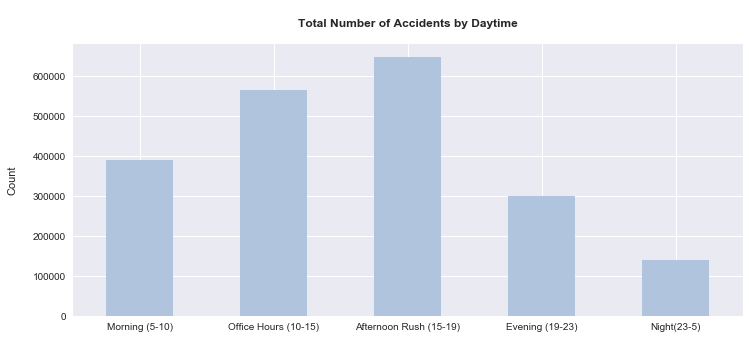

In [44]:
# define labels by accessing look up dictionary above
labels = tuple(daytime_groups.values())

# plot total no. of accidents by daytime
accidents.groupby('Daytime').size().plot(kind='bar', color='lightsteelblue', figsize=(12,5), grid=True)
plt.xticks(np.arange(5), labels, rotation='horizontal')
plt.xlabel(''), plt.ylabel('Count\n')
plt.title('\nTotal Number of Accidents by Daytime\n', fontweight='bold')
sns.despine(top=True, right=True, left=True, bottom=True);

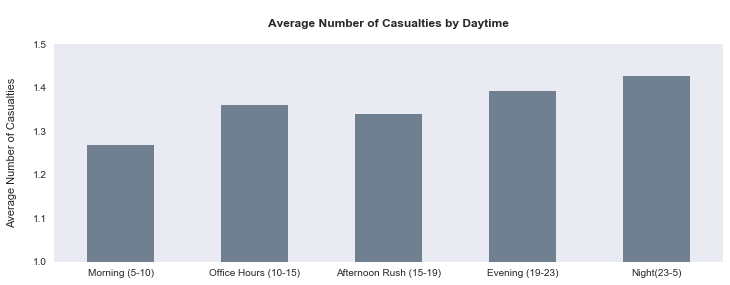

In [45]:
# plot average no. of casualties by daytime
accidents.groupby('Daytime')['Number_of_Casualties'].mean().plot(kind='bar', color='slategrey', 
                                                                 figsize=(12,4), grid=False)
plt.xticks(np.arange(5), labels, rotation='horizontal')
plt.ylim((1,1.5))
plt.xlabel(''), plt.ylabel('Average Number of Casualties\n')
plt.title('\nAverage Number of Casualties by Daytime\n', fontweight='bold')
sns.despine(top=True, right=True, left=True, bottom=True);

#### 2.2. Handling Missing Values
<a id='2.2. Handling Missing Values'></a>

In [46]:
print('Proportion of Missing Values in Accidents Table:', 
      round(accidents.isna().sum().sum()/len(accidents),3), '%')

Proportion of Missing Values in Accidents Table: 0.495 %


In [47]:
#accidents.isna().sum()

In [48]:
# drop columns we don't need
accidents = accidents.drop(columns=['Location_Easting_OSGR', 'Location_Northing_OSGR', 
                                    'Longitude', 'Latitude'])

# drop remaining records with NaN's
accidents = accidents.dropna()

# check if we have no NaN's anymore
accidents.isna().sum().sum()

0

*Back to: <a href='#Table of Contents'> Table of Contents</a>*
#### 2.3. Preparing Dataframe
<a id='2.3. Preparing Dataframe'></a>

In [49]:
# slice columns we want to use
df = accidents[['Accident_Index', 'Accident_Severity', 'Number_of_Vehicles', 'Number_of_Casualties', 'Day_of_Week', 
                'Daytime', 'Road_Type', 'Speed_limit', 'Urban_or_Rural_Area', 'LSOA_of_Accident_Location']]
df.isna().sum().sum()

0

In [50]:
#df.info()    

In [51]:
# cast categorical features - currently stored as string data - to their proper data format
for col in ['Accident_Severity', 'Day_of_Week', 'Daytime', 'Road_Type', 'Speed_limit', 
            'Urban_or_Rural_Area', 'LSOA_of_Accident_Location']:
    df[col] = df[col].astype('category')
    
#df.info()

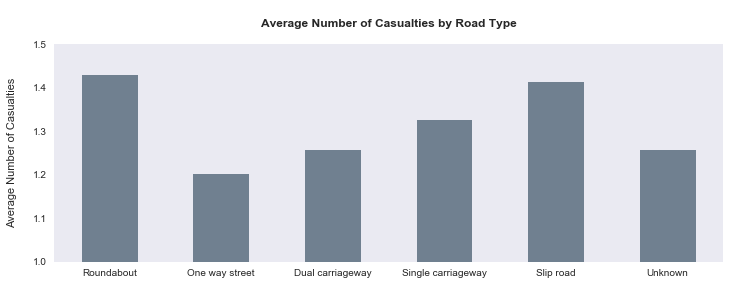

In [52]:
# check road type
df.groupby('Road_Type')['Number_of_Casualties'].mean().plot(kind='bar', color='slategrey', 
                                                            figsize=(12,4), grid=False)
plt.xticks(np.arange(6), 
           ['Roundabout', 'One way street', 'Dual carriageway', 'Single carriageway', 'Slip road', 'Unknown'], 
           rotation='horizontal')
plt.ylim((1,1.5))
plt.xlabel(''), plt.ylabel('Average Number of Casualties\n')
plt.title('\nAverage Number of Casualties by Road Type\n', fontweight='bold')
sns.despine(top=True, right=True, left=True, bottom=True);

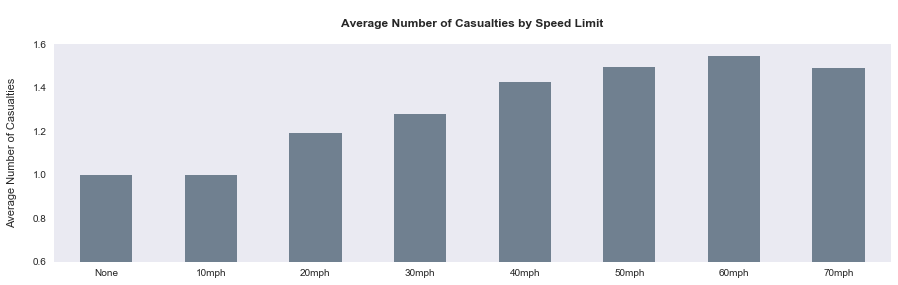

In [53]:
# check speed limit
df.groupby('Speed_limit')['Number_of_Casualties'].mean().plot(kind='bar', color='slategrey', 
                                                              figsize=(15,4), grid=False)
plt.xticks(np.arange(8), 
           ['None', '10mph', '20mph', '30mph', '40mph', '50mph', '60mph', '70mph'], 
           rotation='horizontal')
plt.ylim((0.6,1.6))
plt.xlabel(''), plt.ylabel('Average Number of Casualties\n')
plt.title('\nAverage Number of Casualties by Speed Limit\n', fontweight='bold')
sns.despine(top=True, right=True, left=True, bottom=True);

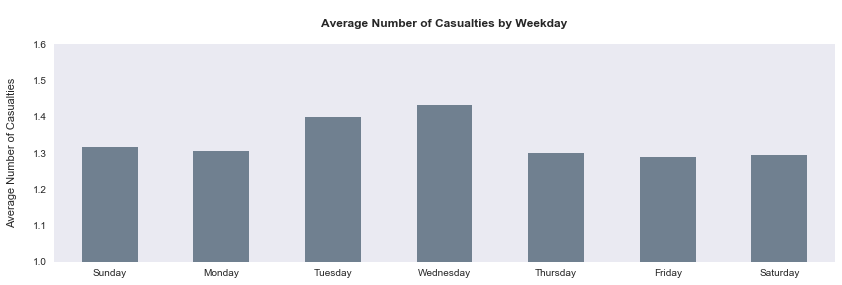

In [54]:
# check daytime
df.groupby('Day_of_Week')['Number_of_Casualties'].mean().plot(kind='bar', color='slategrey', 
                                                              figsize=(14,4), grid=False)
plt.xticks(np.arange(7), 
           ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday'], 
           rotation='horizontal')
plt.ylim((1.0,1.6))
plt.xlabel(''), plt.ylabel('Average Number of Casualties\n')
plt.title('\nAverage Number of Casualties by Weekday\n', fontweight='bold')
sns.despine(top=True, right=True, left=True, bottom=True);

*Back to: <a href='#Table of Contents'> Table of Contents</a>*
#### 2.4. Handling Numerical Data 
<a id='2.4. Handling Numerical Data'></a>

*Detecting Outliers*

In [55]:
# define numerical columns
num_cols = ['Number_of_Casualties']

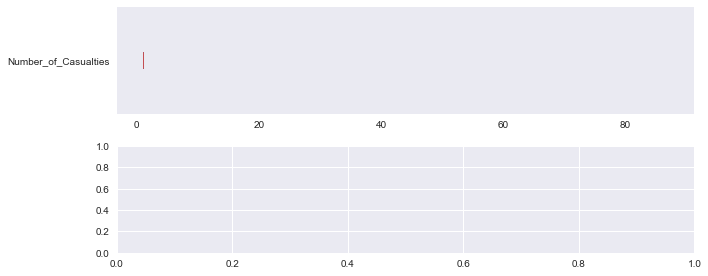

In [56]:
# plotting boxplots
sns.set(style='darkgrid')
fig, axes = plt.subplots(2,1, figsize=(10,4))

for ax, col in zip(axes, num_cols):
    df.boxplot(column=col, grid=False, vert=False, ax=ax)
    plt.tight_layout();

In [57]:
#df['Number_of_Vehicles'].value_counts().head(10)

In [58]:
#df['Number_of_Casualties'].value_counts().head(20)

*Handling Outliers*

In [59]:
# phrasing conditionto cut off extreme outliers
condition = (df['Number_of_Vehicles'] < 6) & (df['Number_of_Casualties'] < 9)

# keep only records that meet our condition
df = df[condition]

# check
print(df['Number_of_Vehicles'].value_counts())

2    784734
1    250753
3     77860
4     12980
5      2374
Name: Number_of_Vehicles, dtype: int64


In [60]:
print(df['Number_of_Casualties'].value_counts())

1    877175
2    177525
3     48566
4     16487
5      5874
6      2103
7       690
8       281
Name: Number_of_Casualties, dtype: int64


*Binning Numerical Features*

... not applicable ...

*Feature Scaling*

... not applicable ...

(Tree based models, which we will use here later, are not distance based models and can handle varying ranges of features. Therefore scaling is not required.)

*Back to: <a href='#Table of Contents'> Table of Contents</a>*
#### 2.5. Handling Categorical Data
<a id='2.5. Handling Categorical Data'></a>

*Binning Categorical Features*

What is `LSOA_of_Accident_Location`? 

- A Lower Layer Super Output Area (LSOA) is a GEOGRAPHIC AREA. Lower Layer Super Output Areas are a geographic hierarchy designed to improve the reporting of small area statistics in England and Wales.

- Lower Layer Super Output Areas are built from groups of contiguous Output Areas and have been automatically generated to be as consistent in population size as possible, and typically contain from four to six Output Areas. The Minimum population is 1000 and the mean is 1500.

- There is a Lower Layer Super Output Area for each POSTCODE in England and Wales. A pseudo code is available for Scotland, Northern Ireland, Channel Islands and the Isle of Man.

Location might be a good predictor for the number of casualties - but not on such a granular level. We would need to aggregate location to bigger areas. The look up table I needed to convert the LSOA to MSOA can be found [here](https://geoportal.statistics.gov.uk/datasets/output-area-to-lsoa-to-msoa-to-local-authority-district-december-2017-lookup-with-area-classifications-in-great-britain).

In [63]:
df.head(2)

,Accident_Index,Accident_Severity,Number_of_Vehicles,Number_of_Casualties,Day_of_Week,Daytime,Road_Type,Speed_limit,Urban_or_Rural_Area,LSOA_of_Accident_Location
1,200501BS00002,Slight,1,1,Wednesday,3,Dual carriageway,30.0,Urban,E01002909
6,200501BS00007,Slight,2,1,Thursday,4,Single carriageway,30.0,Urban,E01002875


In [64]:
look_up = pd.read_csv('LSOA_to_MSOA_to_Local_Authority_District_Dec_2017_Lookup.csv')
look_up.head(2)

,OA11CD,OAC11CD,OAC11NM,LSOA11CD,LSOA11NM,SOAC11CD,SOAC11NM,MSOA11CD,MSOA11NM,LAD17CD,LAD17NM,LACCD,LACNM,RGN11CD,RGN11NM,CTRY11CD,CTRY11NM,FID
0,E00070834,1a2,Established Farming Communities,E01014030,Herefordshire 009D,2b,Prospering countryside life,E02002913,Herefordshire 009,E06000019,"Herefordshire, County of",3a2r,Sparse English and Welsh Countryside,E12000005,West Midlands,E92000001,England,11001
1,E00070835,1a2,Established Farming Communities,E01014028,Herefordshire 009B,2a,Ageing rural neighbourhoods,E02002913,Herefordshire 009,E06000019,"Herefordshire, County of",3a2r,Sparse English and Welsh Countryside,E12000005,West Midlands,E92000001,England,11002


To aggregate our accidents locations to counties, let's merge our dataframe with the look up table. The counties here are stored in the `LSOA11NM` column.

The *keys* to combine both dataframes are `LSOA_of_Accident_Location` in our dataframe and `LSOA11CD` in our look up table. Both contain the the LSOA location for each accident:

In [65]:
df_merged = pd.merge(df, look_up[['LSOA11CD', 'LAD17NM']], how='left', 
                     left_on='LSOA_of_Accident_Location', right_on='LSOA11CD')
df_merged.head(2)

ValueError: Buffer dtype mismatch, expected 'Python object' but got 'double'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'double'


,Accident_Index,Accident_Severity,Number_of_Vehicles,Number_of_Casualties,Day_of_Week,Daytime,Road_Type,Speed_limit,Urban_or_Rural_Area,LSOA_of_Accident_Location,LSOA11CD,LAD17NM
0,200501BS00002,Slight,1,1,Wednesday,3,Dual carriageway,30.0,Urban,E01002909,E01002909,Kensington and Chelsea
1,200501BS00002,Slight,1,1,Wednesday,3,Dual carriageway,30.0,Urban,E01002909,E01002909,Kensington and Chelsea


In [66]:
# drop the key columns, rename the inconveniently named column, ...
# ... cast it to a categorical datetype, and drop duplicates
df_merged = df_merged.drop(columns=['LSOA_of_Accident_Location', 'LSOA11CD','Number_of_Vehicles'])\
                        .rename(columns={'LAD17NM': 'County_of_Accident'})\
                            .astype({'County_of_Accident': 'category'})\
                                .drop_duplicates()

df_merged.head(2)

,Accident_Index,Accident_Severity,Number_of_Casualties,Day_of_Week,Daytime,Road_Type,Speed_limit,Urban_or_Rural_Area,County_of_Accident
0,200501BS00002,Slight,1,Wednesday,3,Dual carriageway,30.0,Urban,Kensington and Chelsea
6,200501BS00007,Slight,1,Thursday,4,Single carriageway,30.0,Urban,Kensington and Chelsea


In [67]:
df_merged.shape

(1128701, 9)

In [68]:
#df_merged.groupby('County_of_Accident').size().sort_values(ascending=False).head()

In [69]:
df_plot = df_merged.groupby('County_of_Accident').size().reset_index().rename(columns={0:'Count'})
df_plot.head()

,County_of_Accident,Count
0,Adur,1238
1,Allerdale,1476
2,Amber Valley,1858
3,Arun,2567
4,Ashfield,2663


In [70]:
# define numerical feature column
num_col = []

# define categorical feature columns
cat_cols = ['Accident_Severity', 'Day_of_Week', 'Daytime', 'Road_Type', 'Speed_limit', 
            'Urban_or_Rural_Area', 'County_of_Accident']

# define target column
target_col = ['Number_of_Casualties']

cols = cat_cols + num_cols + target_col

# copy dataframe
df_model = df_merged[cols].copy()
df_model.shape

(1128701, 9)

*Encoding Categorical Features*

In [71]:
# create dummy variables from the categorical features
dummies = pd.get_dummies(df_model[cat_cols], drop_first=True)
df_model = pd.concat([df_model[num_cols], df_model[target_col], dummies], axis=1)
df_model.shape

(1128701, 376)

In [72]:
df_model.isna().sum().sum()

0

In [73]:
#df_model.info()

*Back to: <a href='#Table of Contents'> Table of Contents</a>*
### 3. Modeling the Data
<a id='3. Modeling the Data'></a>

#### 3.1. Train-Test-Split
<a id='3.1. Train-Test-Split'></a>

In [74]:
# define our features 
features = df_model.drop(['Number_of_Casualties'], axis=1)

# define our target
target = df_model[['Number_of_Casualties']]

In [75]:
from sklearn.model_selection import train_test_split

# split our data
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2)

*Back to: <a href='#Table of Contents'> Table of Contents</a>*
#### 3.2. Training and Evaluating Random Forest Regressor
<a id='3.2. Training and Evaluating Random Forest Regressor'></a>

In [76]:
# import regressor
from sklearn.ensemble import RandomForestRegressor

# import metrics
from sklearn.metrics import mean_squared_error, r2_score

# import evaluation tools
from sklearn.model_selection import RandomizedSearchCV

C:\Users\User\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [ ]:
# create RandomForestRegressor
forest = RandomForestRegressor(random_state=4, n_jobs=-1)

# train
forest.fit(X_train, y_train)

# predict
y_train_preds = forest.predict(X_train)
y_test_preds  = forest.predict(X_test)

# evaluate
RMSE = np.sqrt(mean_squared_error(y_test, y_test_preds))
print(f"RMSE: {round(RMSE, 4)}")

r2 = r2_score(y_test, y_test_preds)
print(f"r2: {round(r2, 4)}")

In [ ]:
# look at parameters used by our current forest
print('Parameters currently in use:\n')
pprint(forest.get_params())

In [ ]:
# create range of candidate numbers of trees in random forest
n_estimators = [100, 150]

# create range of candidate max. numbers of levels in tree
max_depth = [3, 4, 5]

# create range of candidate min. numbers of samples required to split a node
min_samples_split = [10, 15, 20]

# create dictionary with hyperparameter options
hyperparameters = dict(n_estimators=n_estimators, max_depth=max_depth, min_samples_split=min_samples_split)
hyperparameters

In [ ]:
# create randomized search
#randomized_search = RandomizedSearchCV(forest, hyperparameters, n_jobs=-1)

# fit randomized search
#best_model = randomized_search.fit(X_train, y_train)

# view best parameters
#print(best_model.best_params_)

In [ ]:
# view best value for specific parameter
#print(best_model.best_estimator_.get_params()['n_estimators'])

In [ ]:
# create RandomForestRegressor with best found hyperparameters
forest = RandomForestRegressor(n_estimators=150, max_depth=5, random_state=4, n_jobs=-1)

# train
forest.fit(X_train, y_train)

# predict
y_train_preds = forest.predict(X_train)
y_test_preds  = forest.predict(X_test)

# evaluate
RMSE = np.sqrt(mean_squared_error(y_test, y_test_preds))
print(f"RMSE: {round(RMSE, 4)}")

r2 = r2_score(y_test, y_test_preds)
print(f"r2: {round(r2, 4)}")

In [ ]:
# plot the important features
feat_importances = pd.Series(forest.feature_importances_, index=features.columns)
feat_importances.nlargest(10).sort_values().plot(kind='barh', color='darkgrey', figsize=(10,5))
plt.xlabel('Relative Feature Importance with Random Forest');